In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier
import pandas as pd
from sklearn.preprocessing import LabelBinarizer
from Utils import *
from IPython.display import display

# Loading data

In [2]:
train_stratified_directory = 'GroupedData/train.csv'
validation_directory = 'GroupedData/validation_random.csv'

In [3]:
train_stratified, train_stratified_label = load_shopping_data(train_stratified_directory)
validation, validation_label = load_shopping_data(validation_directory)

# Training

## Random Forest

In [5]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=50)
clf.fit(train_stratified, train_stratified_label.ravel())
train_accuracy = clf.score(train_stratified, train_stratified_label)
testing_accuracy = clf.score(validation, validation_label)
print('Training accuracy =', train_accuracy)
print("Testing accuracy =", testing_accuracy)

Training accuracy = 0.977495672245
Testing accuracy = 0.6154


In [9]:
from collections import OrderedDict

In [14]:
RANDOM_STATE = 1
ensemble_clfs = [
    ("RandomForestClassifier, max_features='sqrt'",
        RandomForestClassifier(warm_start=True, oob_score=True,
                               max_features="sqrt",
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features='log2'",
        RandomForestClassifier(warm_start=True, max_features='log2',
                               oob_score=True,
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features=None",
        RandomForestClassifier(warm_start=True, max_features=None,
                               oob_score=True,
                               random_state=RANDOM_STATE))
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_estimators = 15
max_estimators = 175

In [2]:
for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1):
        clf.set_params(n_estimators=i)
        clf.fit(cv_train, cv_label)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

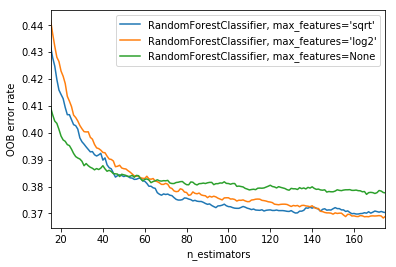

In [16]:
# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

## Cross Validation  

In [13]:
cv_train = np.vstack([train_stratified, validation])
cv_label = np.hstack([train_stratified_label, validation_label])

### Normal KFold Cross Validation

In [21]:
cv_result = crossValidation(cv_train, cv_label, clf, cv=5)

In [22]:
print("The result for each fold is \n", cv_result[:, 0])
print("The average result is %f, with standard deviation of %f" % (cv_result.mean(), cv_result.std()))

The result for each fold is 
 [ 0.6052492   0.59915164  0.60392365  0.61850477  0.60116525]
The average result is 0.605599, with standard deviation of 0.006793


### Stratified Cross Validation

In [23]:
scv_result = scv(cv_train, cv_label, clf, cv = 5)

In [24]:
print("The result for each fold is \n", scv_result[:, 0])
print("The average result is %f, with standard deviation of %f" % (scv_result.mean(), scv_result.std()))

The result for each fold is 
 [ 0.59117897  0.59149703  0.59022477  0.58810433  0.59499576]
The average result is 0.591200, with standard deviation of 0.002237


# Final Classifier

In [6]:
test_directory = 'GroupedData/test_random.csv'
test, test_label = load_shopping_data(test_directory)

In [7]:
testing_accuracy = clf.score(test, test_label)
print('Training accuracy =', train_accuracy)
print("Testing accuracy =", testing_accuracy)

Training accuracy = 0.977495672245
Testing accuracy = 0.5981


## Micro ROC Curve

In [15]:
from sklearn.metrics import roc_curve

In [18]:
y_score = clf.predict_proba(test)
lb = LabelBinarizer()
new_test_label = lb.fit(train_stratified_label).transform(test_label)
fpr, tpr, _ = roc_curve(new_test_label.ravel(), y_score.ravel())

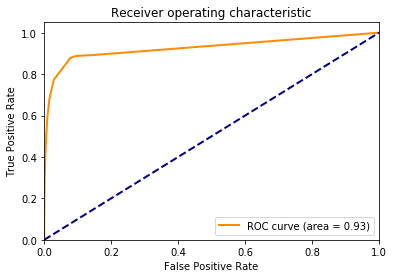

In [19]:
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [30]:
from sklearn.metrics import log_loss
y_pred = clf.predict_proba(test)

In [33]:
log_loss(test_label, y_pred, labels=np.unique(cv_label)) 

4.7404331716146411